In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (20,10)

In [3]:
kld = pd.read_csv('../data/processed/kolding_features.csv', index_col='Datetime', parse_dates=['Datetime'])
kld.head()

,Value,sunshine_mins,airtemp_c,humidity_pct,windspeed_mps,precip_mins,precip_mm
Datetime,,,,,,,
2019-01-01 00:00:00,116.322,0.0,7.850000,87.833333,11.716667,0.0,0.0
2019-01-01 01:00:00,102.681,0.0,7.883333,88.500000,11.983333,0.0,0.0
2019-01-01 02:00:00,96.379,0.0,7.850000,91.500000,11.183333,0.0,0.0
2019-01-01 03:00:00,85.352,0.0,7.983333,93.500000,10.516667,0.0,0.0
2019-01-01 04:00:00,74.842,0.0,8.166667,83.333333,12.666667,1.0,0.1


In [4]:
# Amount of days for validation and test set
print((kld.index.max() - dt.datetime(2021,1,1)) / 2 )

32 days 23:30:00


In [5]:
valid_date = dt.datetime(2021,1,1)
test_date = dt.datetime(2021,1,1) + dt.timedelta(days=33)

train = kld.copy()[kld.index < valid_date]
val = kld.copy()[(kld.index >= valid_date) & (kld.index < test_date)]
test = kld.copy()[kld.index >= test_date]

In [6]:
print(train.shape, val.shape, test.shape)

(17544, 7) (792, 7) (792, 7)


In [7]:
# Normalize
data = kld.to_numpy()

mean = data[:17544].mean(axis=0)
data -= mean
std = data[:17544].std(axis=0)
data /= std

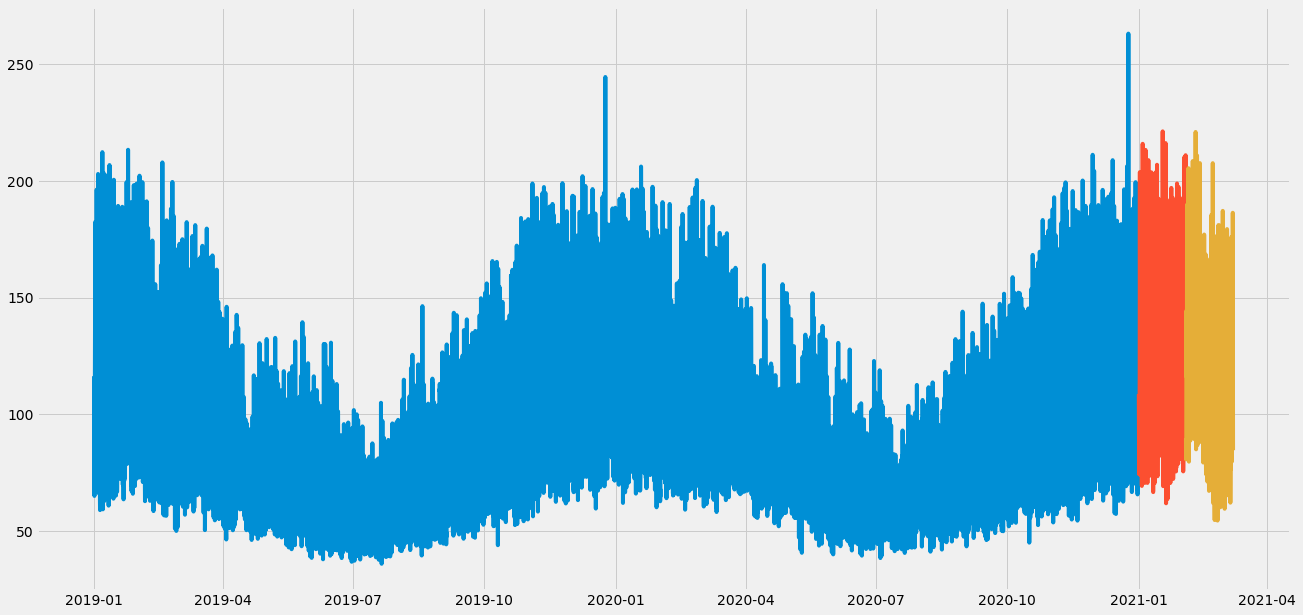

In [8]:
plt.plot(train['Value'])
plt.plot(val['Value'])
plt.plot(test['Value'])
plt.show()

In [9]:
def generator(data, lookback, delay, min_index, max_index, batch_size=128, step=1):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if i + batch_size >= max_index:
            i = min_index + lookback
        rows = np.arange(i, min(i + batch_size, max_index))
        i += len(rows)
        
        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [10]:
lookback = 24*6
step = 1
delay = 24
batch_size = 128

In [11]:
train_gen = generator(data, 
                      lookback=lookback, 
                      delay=delay,
                      min_index=0, 
                      max_index=train.shape[0],
                      step=step,
                      batch_size=batch_size)
val_gen = generator(data, 
                      lookback=lookback, 
                      delay=delay,
                      min_index=train.shape[0]+1, 
                      max_index=train.shape[0]+val.shape[0],
                      step=step,
                      batch_size=batch_size)
test_gen = generator(data, 
                      lookback=lookback, 
                      delay=delay,
                      min_index=train.shape[0]+val.shape[0]+1, 
                      max_index=None,
                      step=step,
                      batch_size=batch_size)

val_steps = ((train.shape[0]+val.shape[0]) - (train.shape[0]+1) - lookback)
test_steps = (len(data) - (train.shape[0]+val.shape[0]+1) - lookback)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

In [70]:
# Basic ML Approach
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                     steps_per_epoch=500,
                     epochs=20,
                     validation_data=val_gen,
                     validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 5s 9ms/step - loss: 1.0547 - val_loss: 0.4085
Epoch 2/20
500/500 [==============================] - 4s 8ms/step - loss: 0.8071 - val_loss: 0.4721
Epoch 3/20
500/500 [==============================] - 4s 8ms/step - loss: 0.5763 - val_loss: 0.4666
Epoch 4/20
500/500 [==============================] - 4s 9ms/step - loss: 0.5736 - val_loss: 0.3960
Epoch 5/20
500/500 [==============================] - 5s 10ms/step - loss: 0.5119 - val_loss: 0.4200
Epoch 6/20
500/500 [==============================] - 5s 10ms/step - loss: 0.4818 - val_loss: 0.3811
Epoch 7/20
500/500 [==============================] - 5s 10ms/step - loss: 0.4829 - val_loss: 0.3837
Epoch 8/20
500/500 [==============================] - 5s 10ms/step - loss: 0.4312 - val_loss: 0.3756
Epoch 9/20
500/500 [==============================] - 5s 9ms/step - loss: 0.4724 - val_loss: 0.4180
Epoch 10/20
500/500 [==============================] - 5s 9ms/step - loss: 0.4285 - val_loss: 0.

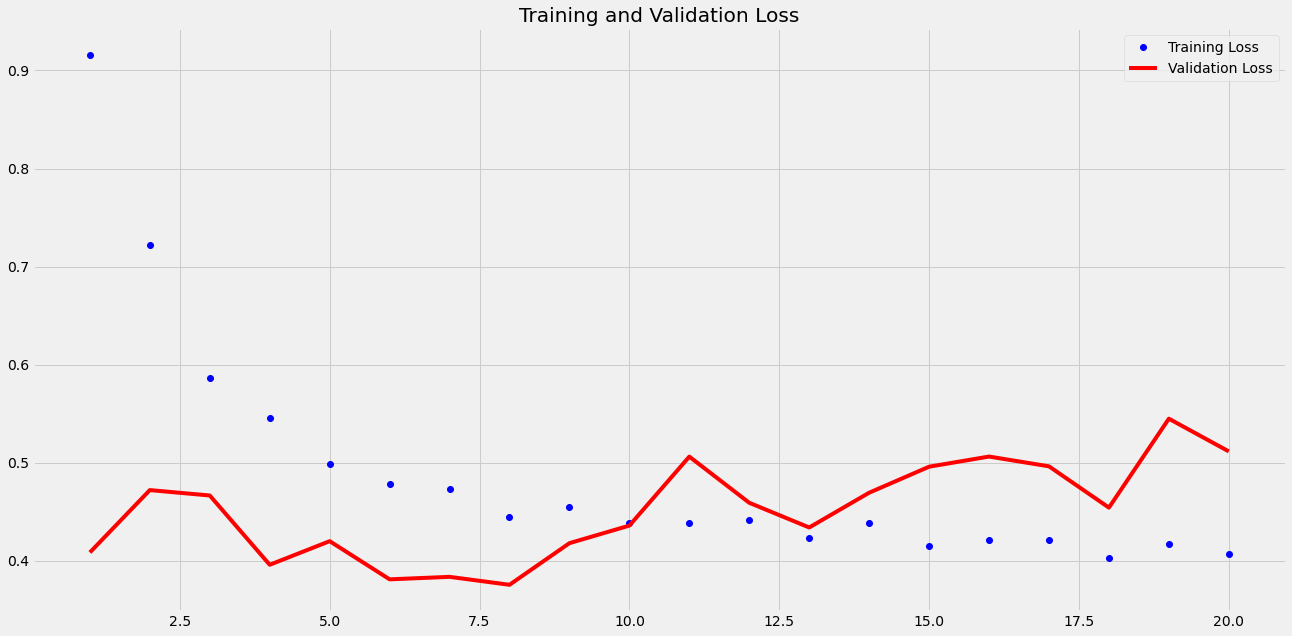

In [75]:
loss =  history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [13]:
# Recurrent Baseline
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                     steps_per_epoch=500,
                     epochs=20,
                     validation_data=val_gen,
                     validation_steps=val_steps)


c:\users\nicol\envs\thesis\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 37s 70ms/step - loss: 0.5844 - val_loss: 0.3233
Epoch 2/20
500/500 [==============================] - 33s 66ms/step - loss: 0.5059 - val_loss: 0.3156TA:  - ET
Epoch 3/20
500/500 [==============================] - 32s 64ms/step - loss: 0.4482 - val_loss: 0.3190
Epoch 4/20
500/500 [==============================] - 32s 65ms/step - loss: 0.5007 - val_loss: 0.3191- loss: 0. - ETA: 2s - loss: 0.5 - ETA:  - ETA: 0s - los
Epoch 5/20
500/500 [==============================] - 34s 68ms/step - loss: 0.4571 - val_loss: 0.2964
Epoch 6/20
500/500 [==============================] - 36s 72ms/step - loss: 0.4548 - val_loss: 0.2938
Epoch 7/20
500/500 [==============================] - 37s 75ms/step - loss: 0.4556 - val_loss: 0.2967
Epoch 8/20
500/500 [==============================] - 36s 73ms/step - loss: 0.4256 - val_loss: 0.3036
Epoch 9/20
500/500 [==============================] - 35s 70ms/step - loss: 0.4621 - val_loss: 0.2947
Epoch 10/20
500/5

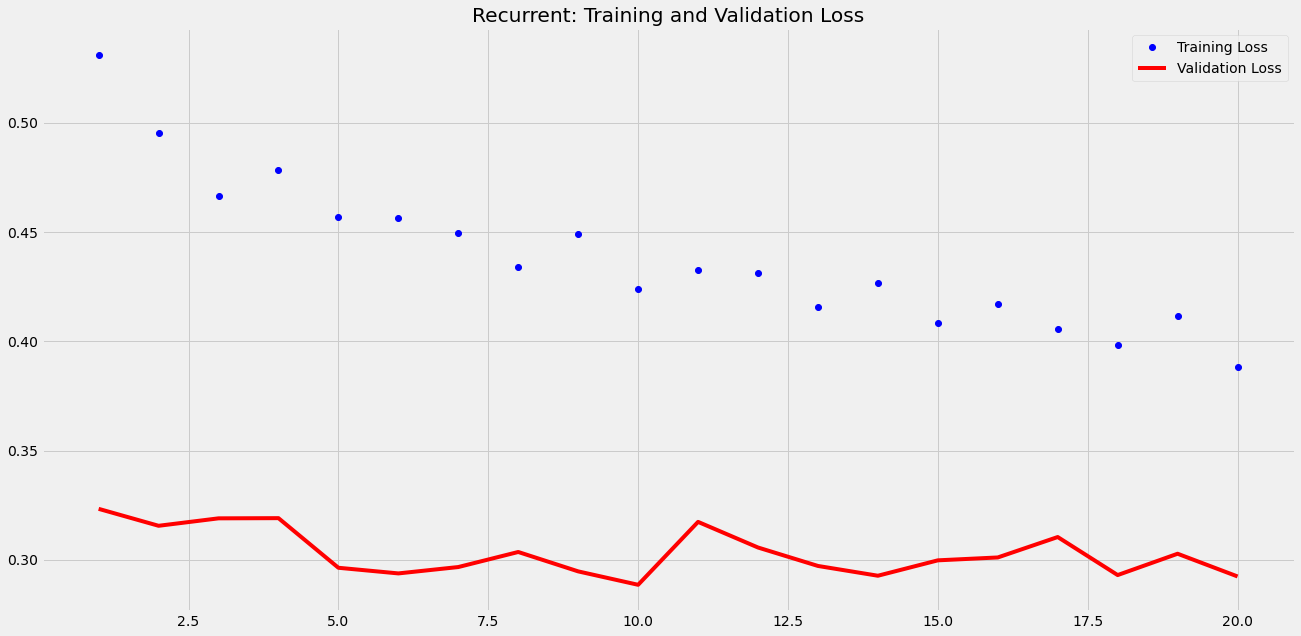

In [14]:
loss =  history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Recurrent: Training and Validation Loss')
plt.legend()

plt.show()